<a href="https://colab.research.google.com/github/fourmodern/targetdiscovery/blob/main/03.OpenTargets_LungCancer_Patched.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open Targets — 폐암(Lung cancer) 표적 탐색 (Schema-patched, 2025-09)

**업데이트 요약**  
- `Disease.ontology`, `Disease.clinicalSignsAndSymptoms` 필드는 **현재 스키마에 없음** → `resolvedAncestors`/`parents`/`children`/`phenotypes`로 대체  
- `associatedTargets`의 정렬 인자(`sortBy`, `order`)는 사용하지 않음(기본 score desc)  
- `knownDrugs`는 `size`/`cursor` 기반 페이지네이션 사용

**파이프라인**
1) 질환 ID 선택 → 2) 연관 표적 Top-N → 3) Known drugs → 4) (선택) 표적 상세 → 5) CSV 저장

In [1]:
#@title 0) 설치/임포트
# !pip -q install requests pandas tqdm
import json, requests, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm

API_URL = "https://api.platform.opentargets.org/api/v4/graphql"
print("API:", API_URL)

API: https://api.platform.opentargets.org/api/v4/graphql


In [2]:
#@title 1) GraphQL 헬퍼
def run_graphql(query: str, variables: dict | None = None, endpoint: str = API_URL, retries: int = 3, timeout: int = 60):
    payload = {"query": query}
    if variables: payload["variables"] = variables
    last_err = None
    for _ in range(retries):
        try:
            r = requests.post(endpoint, json=payload, timeout=timeout)
            if r.status_code != 200:
                last_err = RuntimeError(f"HTTP {r.status_code}: {r.text[:400]}")
            else:
                data = r.json()
                if "errors" in data:
                    last_err = RuntimeError(json.dumps(data["errors"], ensure_ascii=False, indent=2))
                else:
                    return data["data"]
        except Exception as e:
            last_err = e
    raise last_err

def to_df(rows: list[dict], columns: list[str] | None = None) -> pd.DataFrame:
    df = pd.DataFrame(rows)
    if columns is not None:
        for c in columns:
            if c not in df.columns: df[c] = None
        df = df[columns]
    return df

In [3]:
#@title 2) 파라미터
# - MONDO_0008903: lung cancer
# - EFO_0001071: lung carcinoma (상위 개념)
# - EFO_0003060: non-small cell lung carcinoma (NSCLC)
# - EFO_0003071: small cell lung carcinoma (SCLC)
DISEASE_ID = "MONDO_0008903"  #@param ["MONDO_0008903", "EFO_0001071", "EFO_0003060", "EFO_0003071"] {allow-input: true}
TOP_N_TARGETS = 50  #@param {type:"integer"}
print("Disease:", DISEASE_ID, "| Top-N:", TOP_N_TARGETS)

Disease: MONDO_0008903 | Top-N: 50


In [5]:
#@title 3) 질환 기본 정보 (안전한 필드만 사용)
query = """
query diseaseInfo($efoId: String!){
  disease(efoId: $efoId){
    id
    name
    description
    therapeuticAreas{ id name }
    parents{ id name }
    children{ id name }
    resolvedAncestors{ id name }
    descendants
    phenotypes(page:{size:10, index:0}){ count }
  }
}
"""
data = run_graphql(query, {"efoId": DISEASE_ID})
d_info = data["disease"]
print(d_info["id"], d_info["name"])
print("TA:", [ta["name"] for ta in d_info.get("therapeuticAreas", [])])
print("Parents:", [p["name"] for p in d_info.get("parents", [])])
print("Children(n):", len(d_info.get("children", [])), "| Ancestors(n):", len(d_info.get("resolvedAncestors", [])))
print("Phenotypes count:", d_info.get("phenotypes",{}).get("count"))

MONDO_0008903 lung cancer
TA: ['cancer or benign tumor', 'respiratory or thoracic disease']
Parents: ['respiratory system cancer', 'thoracic cancer', 'lung neoplasm']
Children(n): 5 | Ancestors(n): 13
Phenotypes count: 5


In [9]:
#@title 4) 연관 표적 Top-N (score 기본 내림차순)
query = """query diseaseAssociations($efoId: String!, $size: Int!, $index: Int!){
  disease(efoId: $efoId){
    id
    name
    associatedTargets(page:{size:$size, index:$index}){
      count
      rows{
        score
        datasourceScores{ id score }
        target{
          id
          approvedSymbol
          approvedName
          tractability{ modality label value }
        }
      }
    }
  }
}
"""
data = run_graphql(query, {"efoId": DISEASE_ID, "size": TOP_N_TARGETS, "index": 0})
assoc = data["disease"]["associatedTargets"]
rows = assoc["rows"]
flat = []
for r in rows:
    t = r["target"]
    flat.append({
        "target_id": t["id"],
        "symbol": t["approvedSymbol"],
        "name": t.get("approvedName"),
        "assoc_score": r["score"],
        "datasources": ";".join([f"{ds['id']}:{round(ds['score'],3)}" for ds in r.get("datasourceScores", [])]),
        "tractability": ",".join(sorted(set([f"{x.get('modality')}:{x.get('label')}" for x in (t.get("tractability") or [])]))),
    })
df_assoc = to_df(flat, ["symbol","name","assoc_score","datasources","tractability","target_id"]).sort_values("assoc_score", ascending=False).reset_index(drop=True)
df_assoc.head(10)

,symbol,name,assoc_score,datasources,tractability,target_id
0,EGFR,epidermal growth factor receptor,0.901000,chembl:0.991;cancer_gene_census:0.945;eva:0.93...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000146648
1,KRAS,"KRAS proto-oncogene, GTPase",0.847954,intogen:0.933;cancer_gene_census:0.922;eva_som...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000133703
2,TP53,tumor protein p53,0.831853,intogen:0.962;cancer_gene_census:0.942;eva_som...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000141510
3,ALK,ALK receptor tyrosine kinase,0.827696,chembl:0.984;cancer_gene_census:0.957;eva_soma...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000171094
4,ERBB2,erb-b2 receptor tyrosine kinase 2,0.822853,chembl:0.946;eva_somatic:0.866;uniprot_variant...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000141736
5,MET,"MET proto-oncogene, receptor tyrosine kinase",0.822031,chembl:0.978;cancer_gene_census:0.921;eva_soma...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000105976
6,BRAF,"B-Raf proto-oncogene, serine/threonine kinase",0.816422,eva_somatic:0.891;intogen:0.878;eva:0.872;geno...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000157764
7,RB1,RB transcriptional corepressor 1,0.801694,intogen:0.929;cancer_gene_census:0.896;eva:0.8...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000139687
8,PIK3CA,"phosphatidylinositol-4,5-bisphosphate 3-kinase...",0.786540,intogen:0.892;eva_somatic:0.849;eva:0.765;canc...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000121879
9,DICER1,"dicer 1, ribonuclease III",0.782450,eva:0.922;cancer_gene_census:0.86;genomics_eng...,"AB:Advanced Clinical,AB:Approved Drug,AB:GO CC...",ENSG00000100697


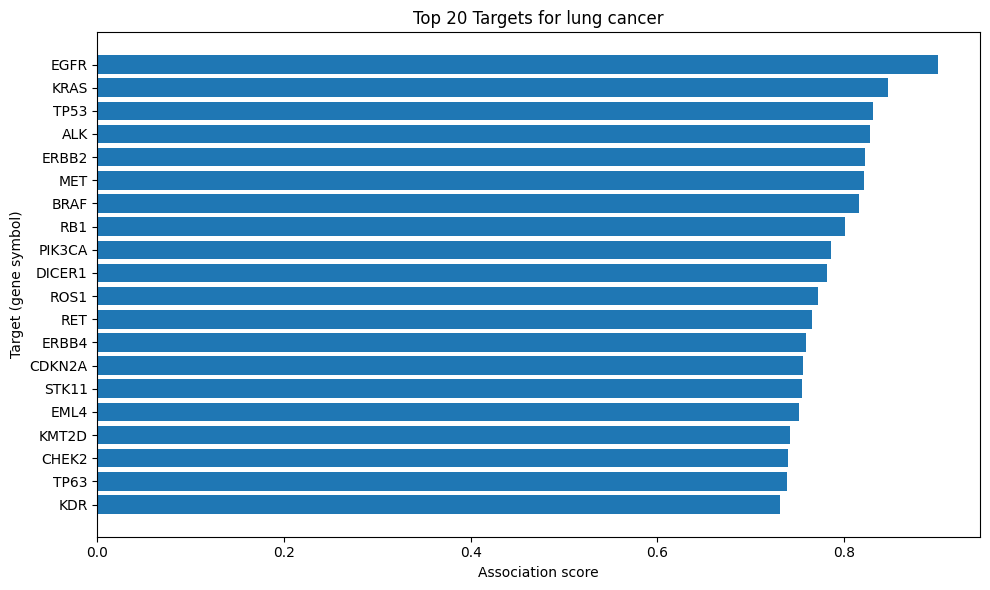

In [10]:
#@title 5) Plot — 상위 20 표적
topk = min(20, len(df_assoc))
plt.figure(figsize=(10,6))
plt.barh(df_assoc["symbol"][:topk][::-1], df_assoc["assoc_score"][:topk][::-1])
plt.xlabel("Association score")
plt.ylabel("Target (gene symbol)")
plt.title(f"Top {topk} Targets for {d_info['name']}")
plt.tight_layout(); plt.show()

In [12]:
#@title 6) Known Drugs
query = """query diseaseKnownDrugs($efoId: String!, $size: Int!){
  disease(efoId: $efoId){
    id
    name
    knownDrugs(size: $size){
      count
      rows{
        drug{ id name drugType }
        target{ approvedSymbol }
        mechanismOfAction
        phase
        references{ source urls }
      }
    }
  }
}
"""
data = run_graphql(query, {"efoId": DISEASE_ID, "size": 200})
kd = data["disease"]["knownDrugs"]
flat = []
for r in kd["rows"]:
  refs = r.get("references") or []
  urls = sorted({u for ref in refs for u in (ref.get("urls") or [])})
  flat.append({
    "drug_name": r["drug"]["name"],
    "drug_type": r["drug"].get("drugType"),
    "target_symbol": (r.get("target") or {}).get("approvedSymbol"),
    "mechanism": r.get("mechanismOfAction"),
    "phase": r.get("phase"),
    "refs(n)": len(urls),
    "first_ref": urls[0] if urls else None
  })
df_drugs = to_df(flat, ["drug_name","drug_type","target_symbol","mechanism","phase","refs(n)","first_ref"]).sort_values(["phase","drug_name"], ascending=[False, True]).reset_index(drop=True)
df_drugs.head(20)

,drug_name,drug_type,target_symbol,mechanism,phase,refs(n),first_ref
0,ADAGRASIB,Small molecule,KRAS,GTPase KRas inhibitor,4,0,None
1,AFATINIB DIMALEATE,Small molecule,EGFR,Epidermal growth factor receptor erbB1 inhibitor,4,0,None
2,AFATINIB DIMALEATE,Small molecule,ERBB2,Receptor protein-tyrosine kinase erbB-2 inhibitor,4,0,None
3,AFATINIB DIMALEATE,Small molecule,ERBB4,Receptor protein-tyrosine kinase erbB-4 inhibitor,4,0,None
4,AFATINIB DIMALEATE,Small molecule,ERBB2,Receptor protein-tyrosine kinase erbB-2 inhibitor,4,0,None
5,AFATINIB DIMALEATE,Small molecule,EGFR,Epidermal growth factor receptor erbB1 inhibitor,4,0,None
6,AFATINIB DIMALEATE,Small molecule,ERBB4,Receptor protein-tyrosine kinase erbB-4 inhibitor,4,0,None
7,ALECTINIB HYDROCHLORIDE,Small molecule,EML4,EML4-ALK,4,0,None
8,ALECTINIB HYDROCHLORIDE,Small molecule,RET,Tyrosine-protein kinase receptor RET inhibitor,4,0,None
9,ALECTINIB HYDROCHLORIDE,Small molecule,ALK,EML4-ALK,4,0,None


In [24]:
#@title 7) (선택) 표적 상세 — id 기반 Ensembl 조회
TOP_TARGETS_FOR_DETAIL = 10  #@param {type:"integer"}
ens_ids = df_assoc["target_id"].head(TOP_TARGETS_FOR_DETAIL).tolist()

target_query = """
query targetInfo($id: String!){
  target(id: $id){
    id
    approvedSymbol
    approvedName
    tractability{ modality label value }
    coreEssentiality{ isEssential source }
    baselineExpression{ tissue label level }
    chemicalProbes{ name }
  }
}
"""

rows, fail_ids = [], []
for eid in ens_ids:
    try:
        out = run_graphql(target_query, {"id": eid})
        t = out.get("target")
        if not t or not t.get("approvedSymbol"):
            fail_ids.append(eid); continue
        rows.append({
            "symbol": t["approvedSymbol"],
            "name": t.get("approvedName"),
            "essential": any(e.get("isEssential") for e in (t.get("coreEssentiality") or [])),
            "tractability": ";".join(sorted({
                f"{x.get('modality')}:{x.get('label')}"
                for x in (t.get("tractability") or [])
                if x
            })),
            "baseline_exp(n)": len(t.get("baselineExpression") or []),
            "chemical_probes(n)": len(t.get("chemicalProbes") or []),
        })
    except Exception:
        fail_ids.append(eid)

import pandas as pd
df_target_detail = pd.DataFrame(rows)
if not df_target_detail.empty:
    df_target_detail = df_target_detail.sort_values("symbol").reset_index(drop=True)

print(f"Fetched {len(df_target_detail)} targets. Failed: {len(fail_ids)}")
if fail_ids:
    print("Failed IDs (up to 5):", fail_ids[:5])

df_target_detail

Fetched 0 targets. Failed: 10
Failed IDs (up to 5): ['ENSG00000146648', 'ENSG00000133703', 'ENSG00000141510', 'ENSG00000171094', 'ENSG00000141736']


""


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

In [34]:
from collections import Counter
from typing import Any, List, Tuple, Optional

def summarize_expressions(expressions: Any) -> Tuple[Optional[float], Optional[Any]]:
    """
    expressions: list-like of dicts. Each item may have:
      - {"rna": {"value": float}, "protein": {"level": <str|float|int>}, ...}
    Returns:
      (rna_expr_max, protein_level_mode)
    """
    if not isinstance(expressions, list) or not expressions:
        return None, None

    rna_vals: List[float] = []
    protein_levels: List[Any] = []

    for e in expressions:
        if not isinstance(e, dict):
            continue
        rna = e.get("rna")
        if isinstance(rna, dict):
            rv = rna.get("value")
            if isinstance(rv, (int, float)):
                rna_vals.append(float(rv))

        protein = e.get("protein")
        if isinstance(protein, dict):
            pl = protein.get("level")
            # level은 범주형(예: HIGH/MED/LOW)일 수도, 수치일 수도 있음
            if pl is not None:
                protein_levels.append(pl)

    rna_expr_max = max(rna_vals) if rna_vals else None
    protein_level_mode = Counter(protein_levels).most_common(1)[0][0] if protein_levels else None
    return rna_expr_max, protein_level_mode


In [35]:


assoc_query = """
query getDiseaseAssociatedTargets($efoId: String!, $size: Int!, $index: Int!) {
  disease(efoId: $efoId) {
    id
    name
    associatedTargets(page: {size: $size, index: $index}) {
      count
      rows {
        score
        target {
          id
          approvedSymbol
          approvedName
          tractability { label modality value }
          expressions {
            rna { value }
            protein { level }
          }
        }
      }
    }
  }
}
"""

data = run_graphql(assoc_query, {"efoId": DISEASE_ID, "size": 50, "index": 0})
ats = data["disease"]["associatedTargets"]["rows"]

import pandas as pd
records = []
for r in ats:
    t = r["target"]
    tract = t.get("tractability") or []
    tract_str = ", ".join(
        f"{x.get('modality')}:{x.get('label')}"
        for x in tract
        if isinstance(x, dict) and x.get("modality") and x.get("label")
    )

    rna_val, prot_lvl = summarize_expressions(t.get("expressions"))

    records.append({
        "symbol": t.get("approvedSymbol"),
        "name": t.get("approvedName"),
        "ensembl_id": t.get("id"),
        "assoc_score": r.get("score"),
        "tractability": tract_str,
        "rna_expr_max": rna_val,
        "protein_level_mode": prot_lvl,
    })

df_assoc_min = pd.DataFrame(records).sort_values("assoc_score", ascending=False).reset_index(drop=True)
df_assoc_min.head(15)


,symbol,name,ensembl_id,assoc_score,tractability,rna_expr_max,protein_level_mode
0,EGFR,epidermal growth factor receptor,ENSG00000146648,0.901000,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",30576.0,-1
1,KRAS,"KRAS proto-oncogene, GTPase",ENSG00000133703,0.847954,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",13955.0,-1
2,TP53,tumor protein p53,ENSG00000141510,0.831853,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",4878.0,-1
3,ALK,ALK receptor tyrosine kinase,ENSG00000171094,0.827696,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",358.0,-1
4,ERBB2,erb-b2 receptor tyrosine kinase 2,ENSG00000141736,0.822853,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",14891.0,-1
5,MET,"MET proto-oncogene, receptor tyrosine kinase",ENSG00000105976,0.822031,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",8719.0,-1
6,BRAF,"B-Raf proto-oncogene, serine/threonine kinase",ENSG00000157764,0.816422,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",26421.5,-1
7,RB1,RB transcriptional corepressor 1,ENSG00000139687,0.801694,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",6931.5,-1
8,PIK3CA,"phosphatidylinositol-4,5-bisphosphate 3-kinase...",ENSG00000121879,0.786540,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",30909.5,-1
9,DICER1,"dicer 1, ribonuclease III",ENSG00000100697,0.782450,"SM:Approved Drug, SM:Advanced Clinical, SM:Pha...",44487.5,-1


In [36]:
#@title 8) CSV 저장
prefix = f"opentargets_lung_{DISEASE_ID}_{pd.Timestamp.now().date()}"
df_assoc.to_csv(prefix + "_associations.csv", index=False)
df_drugs.to_csv(prefix + "_known_drugs.csv", index=False)
if 'df_target_detail' in globals() and len(df_target_detail):
    df_target_detail.to_csv(prefix + "_target_details.csv", index=False)
print("Saved:", prefix + "_*.csv")

Saved: opentargets_lung_MONDO_0008903_2025-09-03_*.csv


## 다음 액션
- 질환 ID를 NSCLC/SCLC 등으로 바꿔 반복 실행 → 점수/약물 라인업 비교  
- `datasourceScores`에서 **GWAS/coloc/finemapping** 기여 큰 표적 가중 → 유전적 인과성 중심 랭킹  
- `tractability` 카테고리(저분자/항체/이중항체/PROTAC)별 필터링 후 우선순위 선정  
- 내부 omics/스크리닝 데이터와 교차검증 → 후보 리스트 축소